<a href="https://colab.research.google.com/github/PabloCeb2000/Titanic_Kaggle/blob/main/Reto_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto Titanic
## Miembros
- Andrea Samantha Aguilar Ramírez
- Adrián Aguilar Sánchez
- Pablo Ceballos Gutiérrez
- Carlos Damián Suárez Bernal

El siguiente reto tiene como objetivo resolver el problema Titanic - Machine Learning from Disaster de Kaggle Competition (https://www.kaggle.com/competitions/titanic/overview) utilizando algoritmos de clasificación. Para ello, se seguirán las siguientes 2 etapas

In [ ]:
import tensorflow as tl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount("/content/gdrive")
!pwd

Mounted at /content/gdrive
/content


### Carga de los datos a partir del dataset 'train.csv'

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/RetoTitanic/titanic/train.csv")
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Identificación de cuantos pasajeros sobrevivieron

Survived
0    549
1    342
Name: count, dtype: int64


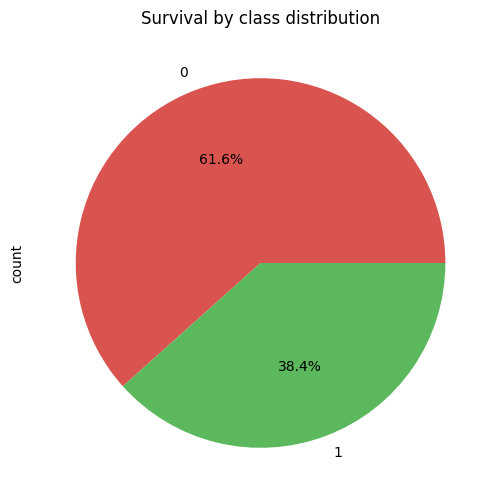

In [ ]:
class_counts = data['Survived'].value_counts()
print(class_counts)

plt.figure(figsize=(8, 6))
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#d9534f', '#5cb85c'])
plt.title('Survival by class distribution')
plt.show()

## Datos Faltantes
### Se identifican los datos que faltan de nuestro dataset,
#### Cantidad de datos faltantes por caracteriztica

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


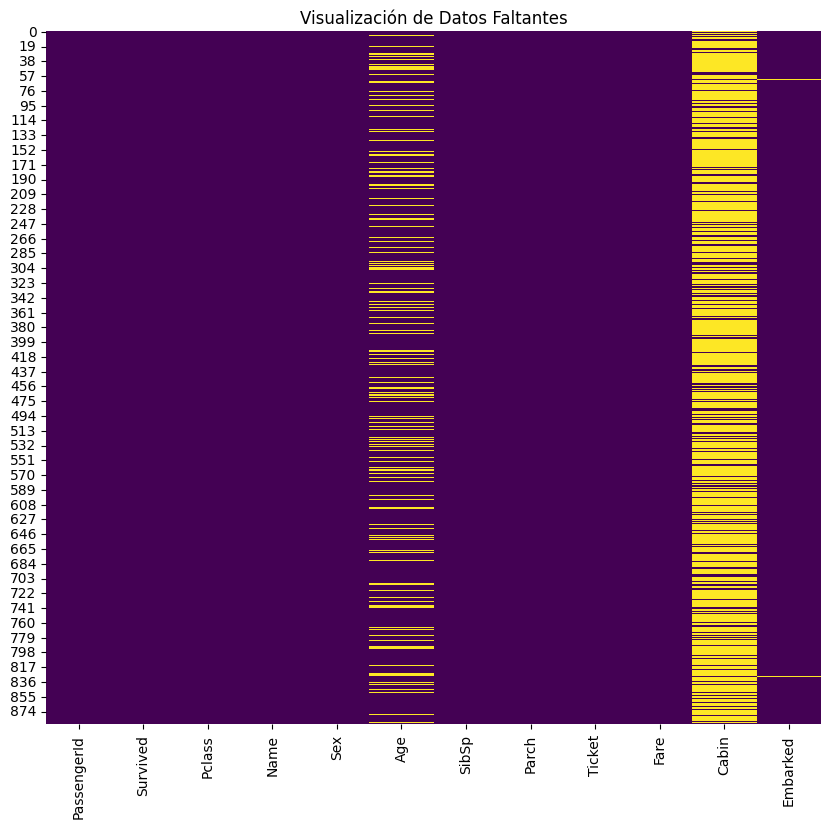

In [ ]:
plt.figure(figsize=(10, 9))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Visualización de Datos Faltantes')
plt.show()

#### Cantidad de datos númericos

In [ ]:
numeric_cols = data.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


#### Cantidad de datos categoricos

In [ ]:
categorical_cols = data.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


#### Decidir qué características requieren imputaciones y cuáles no. Justificar la decisión y eliminar las columnas no seleccionadas

* "Cabin" -> Muchos entradas faltantes
* "Ticket" -> Datos inconcistentes, se usara 'Embarked' en su lugar
* "PassengerId" -> Sin relevancia real para los modelos


In [ ]:
data = data.drop(columns=['Cabin', 'Ticket', 'PassengerId'])

#### Imputación de datos faltantes en la columna 'Age'

Imputación de 'Age' basado en los títulos en 'Name'


In [ ]:
titles = ['Mr', 'Mrs', 'Master', 'Miss']


age_stats = {}
for title in titles:
    subset = data[data['Name'].str.contains(title) & data['Age'].notnull()]
    if not subset.empty:
        mean_age = subset['Age'].mean()
        std_age = subset['Age'].std()
        age_stats[title] = {'mean': mean_age, 'std': std_age}


for title, stats in age_stats.items():
    print(f'Título: {title}, Media: {stats["mean"]:.2f}, Desviación estándar: {stats["std"]:.2f}')

for title, stats in age_stats.items():
    mask = (data['Name'].str.contains(title)) & (data['Age'].isnull())
    mean_age = stats['mean']
    std_age = stats['std']
    num_missing = mask.sum()


    if num_missing > 0:
        generated_ages = np.random.normal(loc=mean_age, scale=std_age, size=num_missing)

        generated_ages = np.clip(generated_ages, a_min=0, a_max=None)
        data.loc[mask, 'Age'] = generated_ages


if data['Age'].isnull().any():
    mean_age = data['Age'].mean()
    data['Age'].fillna(mean_age, inplace=True)

Título: Mr, Media: 33.12, Desviación estándar: 12.53
Título: Mrs, Media: 35.64, Desviación estándar: 11.51
Título: Master, Media: 4.57, Desviación estándar: 3.62
Título: Miss, Media: 21.77, Desviación estándar: 12.99


## 1. Exploración y preprocesamiento de los datos
### Verificar si los datos están balanceados en las clases en las cuales se deben separar los datos

###Analizar la distribución de los datos categóricos y su relación con la clase "survived". Comienza a identificar características relevantes para una clasificación precisa.
#### Análisis por sexo

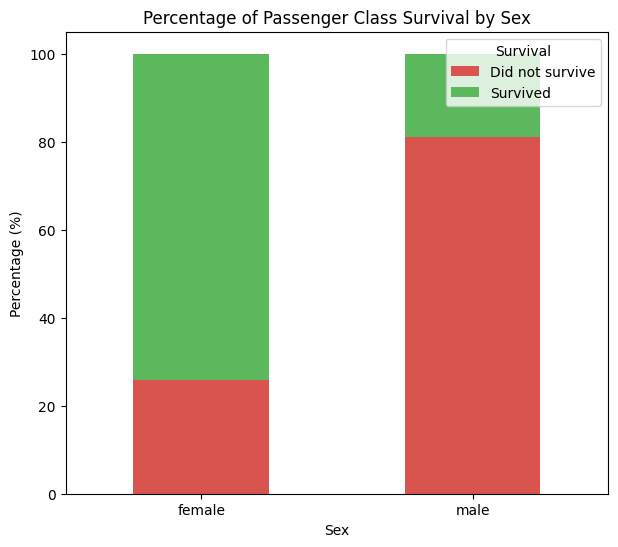

In [ ]:
pclass_counts = data.groupby(['Sex', 'Survived']).size().unstack()
pclass_survival_percentage = pclass_counts.div(pclass_counts.sum(axis=1), axis=0) * 100

pclass_survival_percentage.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(7, 6))
plt.title('Percentage of Passenger Class Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Percentage (%)')
plt.legend(['Did not survive', 'Survived'], title='Survival')
plt.xticks(rotation=0)
plt.show()

#### Análisis por embarked

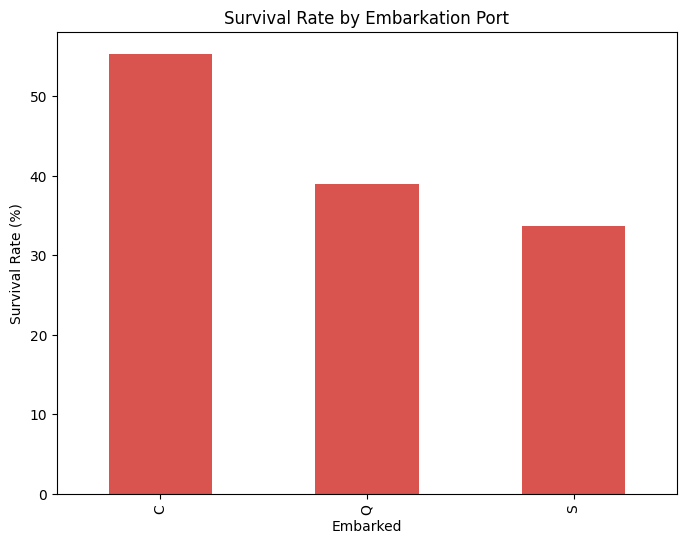

In [ ]:
# Total de personas que embarcaron en cada puerto
total_embarked = data.groupby('Embarked').size()
# Total de sobrevivientes por puerto
survived_embarked = data[data['Survived'] == 1].groupby('Embarked').size()
survival_rate = (survived_embarked / total_embarked) * 100

plt.figure(figsize=(8, 6))
survival_rate.plot(kind='bar', color='#d9534f')
plt.title('Survival Rate by Embarkation Port')
plt.ylabel('Survival Rate (%)')
plt.xlabel('Embarked')
plt.show()

#### Análisis por PClass

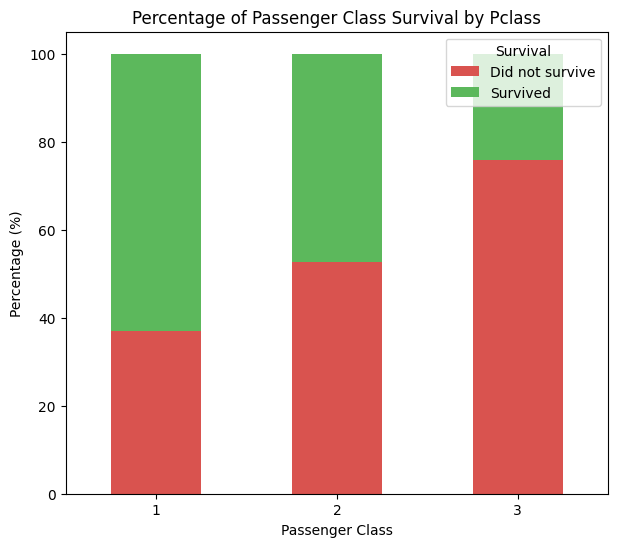

In [ ]:
pclass_counts = data.groupby(['Pclass', 'Survived']).size().unstack()
pclass_survival_percentage = pclass_counts.div(pclass_counts.sum(axis=1), axis=0) * 100


pclass_survival_percentage.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(7, 6))
plt.title('Percentage of Passenger Class Survival by Pclass')
plt.xlabel('Passenger Class')
plt.ylabel('Percentage (%)')
plt.legend(['Did not survive', 'Survived'], title='Survival')
plt.xticks(rotation=0)
plt.show()

Análisis por SibSp

Survived      0      1
SibSp                 
0         398.0  210.0
1          97.0  112.0
2          15.0   13.0
3          12.0    4.0
4          15.0    3.0
5           5.0    NaN
8           7.0    NaN


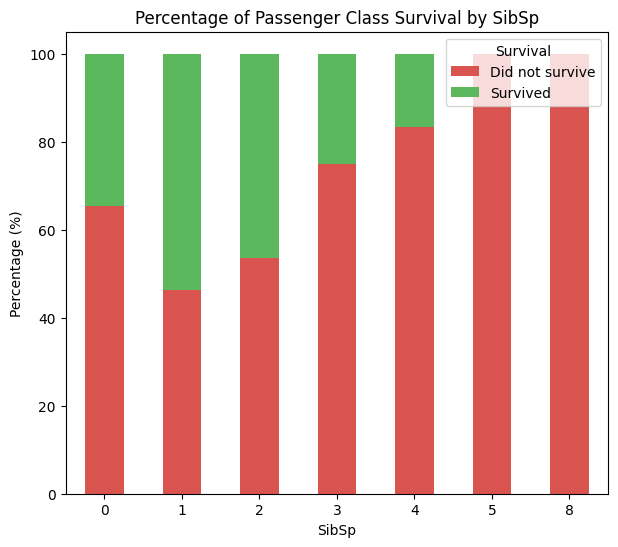

In [ ]:
sibsp_counts = data.groupby(['SibSp', 'Survived']).size().unstack()
print(sibsp_counts)
sibsp_survival_percentage = sibsp_counts.div(sibsp_counts.sum(axis=1), axis=0) * 100


sibsp_survival_percentage.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(7, 6))
plt.title('Percentage of Passenger Class Survival by SibSp')
plt.xlabel('SibSp')
plt.ylabel('Percentage (%)')
plt.legend(['Did not survive', 'Survived'], title='Survival')
plt.xticks(rotation=0)
plt.show()


Análisis por Parch

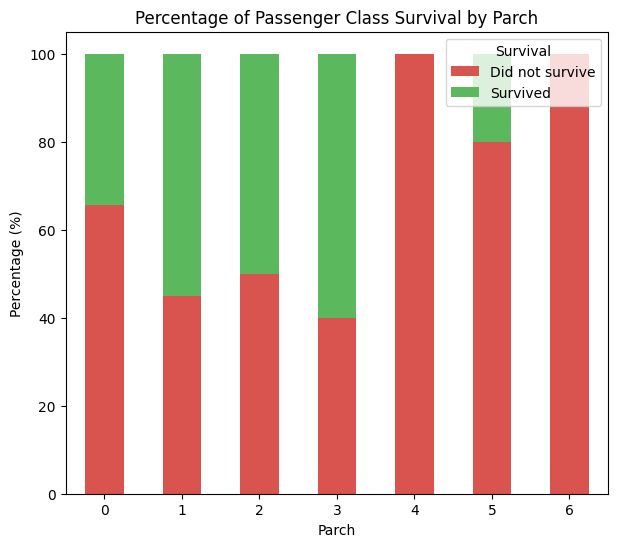

In [ ]:
parch_counts = data.groupby(['Parch', 'Survived']).size().unstack()
parch_survival_percentage = parch_counts.div(parch_counts.sum(axis=1), axis=0) * 100


parch_survival_percentage.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(7, 6))
plt.title('Percentage of Passenger Class Survival by Parch')
plt.xlabel('Parch')
plt.ylabel('Percentage (%)')
plt.legend(['Did not survive', 'Survived'], title='Survival')
plt.xticks(rotation=0)
plt.show()

Análisis de Sex, Fare y Pclass con respecto a Survived

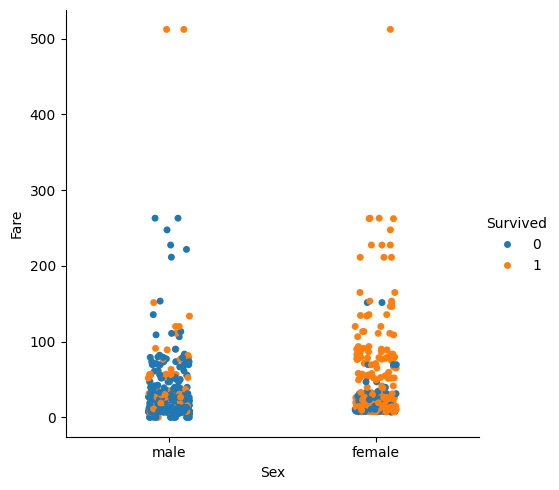

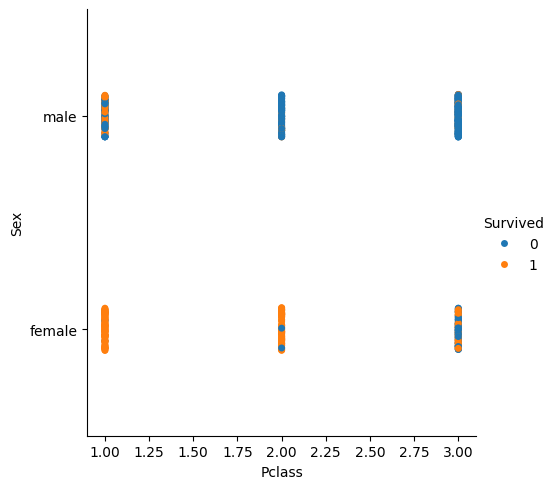

In [ ]:
sns.catplot(data=data, y="Fare",x="Sex", hue="Survived")
sns.catplot(data=data, y="Sex",x="Pclass", hue="Survived")

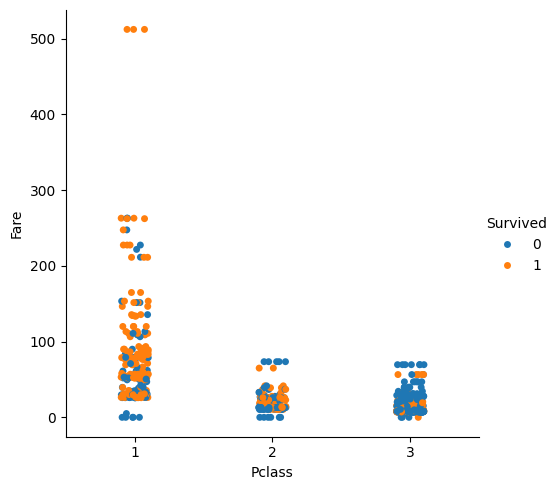

In [ ]:
sns.catplot(data=data, y="Fare",x="Pclass", hue="Survived")

###Comprender la distribución de los datos numéricos y determinar si es necesario aplicar procesos de normalización o estandarización
#### Distribución de edad

<ipython-input-17-4e15d991b003>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['Age'].dropna(), bins=30, kde=True, palette=colors)


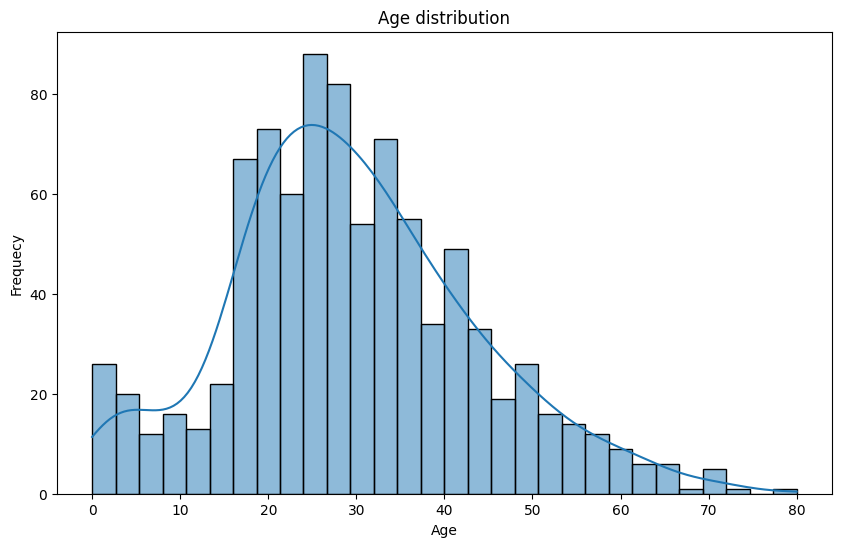

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['#d9534f', '#5cb85c']
sns.histplot(data['Age'].dropna(), bins=30, kde=True, palette=colors)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequecy')
plt.show()

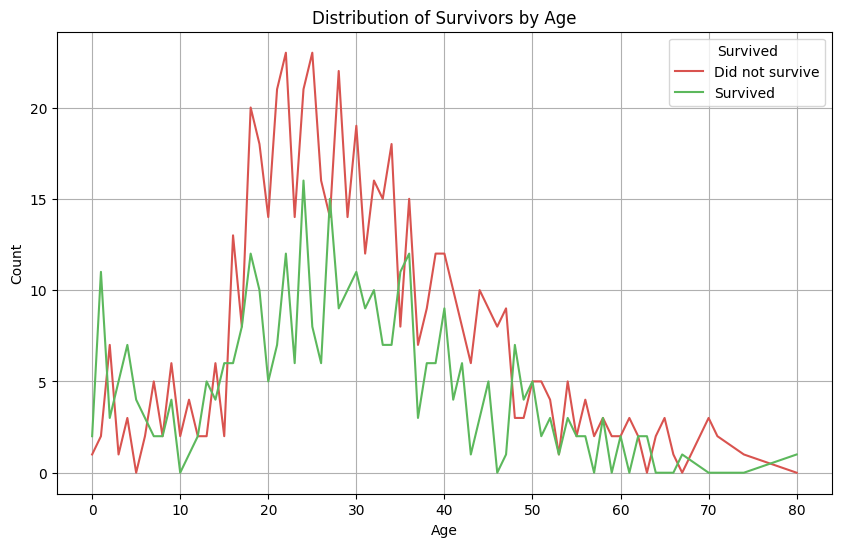

In [ ]:
data['Age_rounded'] = data['Age'].round()
surv_age = data.groupby(['Survived', 'Age_rounded']).size().unstack().fillna(0)
surv_age = surv_age.T

colors = {0: '#d9534f', 1: '#5cb85c'}
plt.figure(figsize=(10, 6))
for survived in surv_age.columns:
    plt.plot(surv_age.index, surv_age[survived], color=colors[survived], label='Survived' if survived == 1 else 'Did not survive')

plt.title('Distribution of Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.grid(True)
plt.show()
data=data.drop(columns=['Age_rounded'])

#### Supervivencia por promedio de edad

<ipython-input-19-163feffc4a07>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_survival_counts = data.groupby(['Age_binned', 'Survived']).size().unstack().fillna(0)


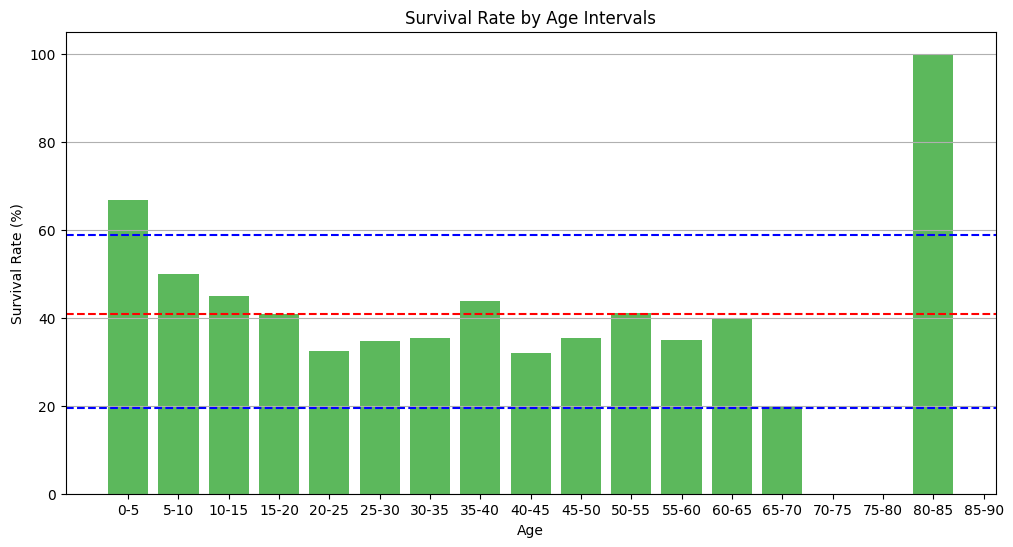

In [ ]:
bins = range(0, 101, 5)
labels = [f'{i}-{i+5}' for i in bins[:-1]]
data['Age_binned'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

age_bin_survival_counts = data.groupby(['Age_binned', 'Survived']).size().unstack().fillna(0)

age_bin_survival_rate = age_bin_survival_counts[1] / age_bin_survival_counts.sum(axis=1) * 100

plt.figure(figsize=(12, 6))
mean_survival_rate = age_bin_survival_rate.mean()

IQ1 = age_bin_survival_rate.quantile(0.25)
IQ3 = age_bin_survival_rate.quantile(0.75)
IQR = IQ3 - IQ1


OUTLIER_THRESHOLD_TOP = IQ3 + 1.5 * IQR
OUTLIER_THRESHOLD_BOTTOM = IQ1 - 1.5 * IQR
plt.bar(age_bin_survival_rate.index, age_bin_survival_rate, color='#5cb85c')

plt.axhline(OUTLIER_THRESHOLD_TOP, color='blue', linestyle='--', label=f'Q1 ({IQ1:.2f}%')
plt.axhline(OUTLIER_THRESHOLD_BOTTOM, color='blue', linestyle='--', label=f'Q3 ({IQ3:.2f}%)')
plt.axhline(mean_survival_rate, color='red', linestyle='--', label=f'Mean Survival Rate ({mean_survival_rate:.2f}%)')
plt.title('Survival Rate by Age Intervals')
plt.xlabel('Age')
plt.ylabel('Survival Rate (%)')

plt.grid(axis='y')
plt.show()
data = data.drop(columns=['Age_binned'])

#### Distribución de fare

#### Distribución por promedio de 'fare'

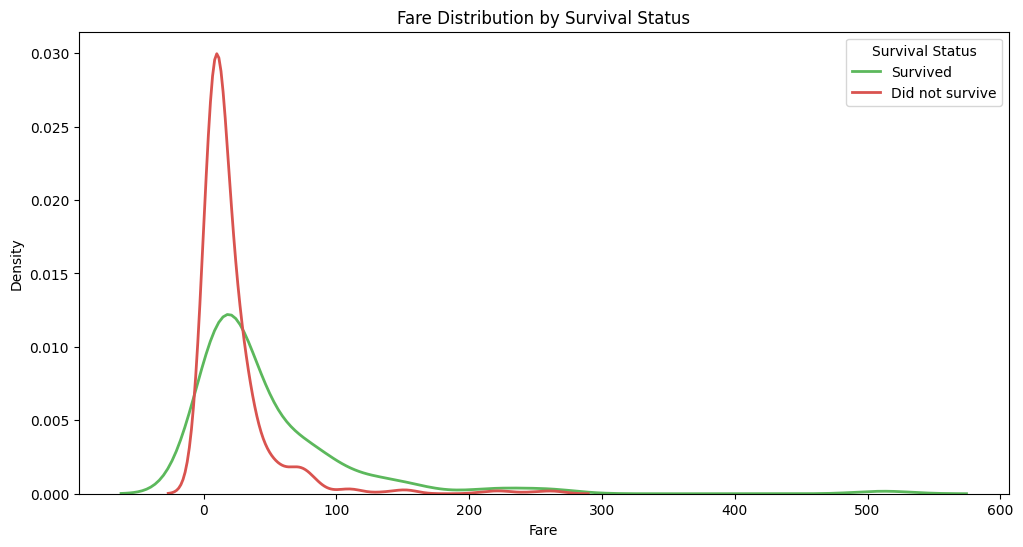

In [ ]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data[data['Survived'] == 1]['Fare'].dropna(),
            color='#5cb85c',
            label='Survived',
            linewidth=2)

sns.kdeplot(data[data['Survived'] == 0]['Fare'].dropna(),
            color='#d9534f',
            label='Did not survive',
            linewidth=2)

plt.title('Fare Distribution by Survival Status')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.legend(title='Survival Status')
plt.show()

#### Distribución entre 'Fare' y 'Pclas'

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


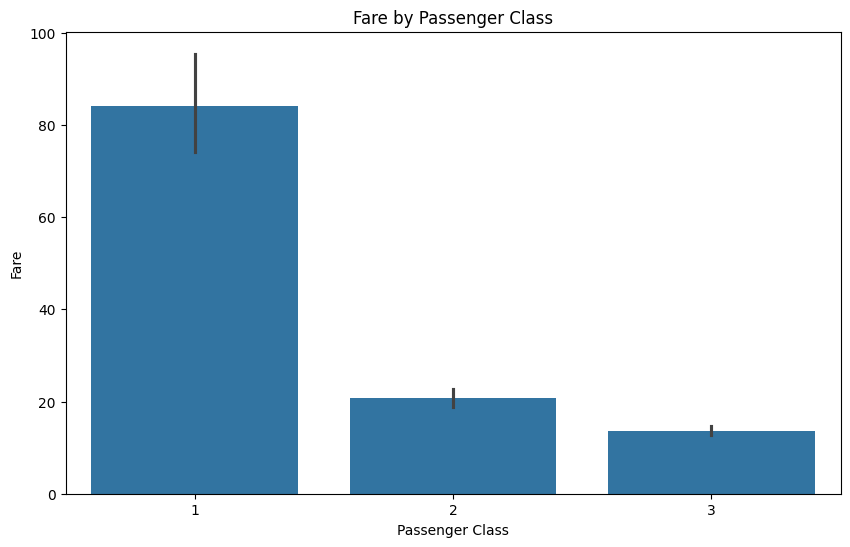

In [ ]:
fare_pclass = data.groupby('Pclass')['Fare'].mean()
print(fare_pclass)
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Fare', data=data)
plt.title('Fare by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()

#### Distribución de 'SibSp'

0
8


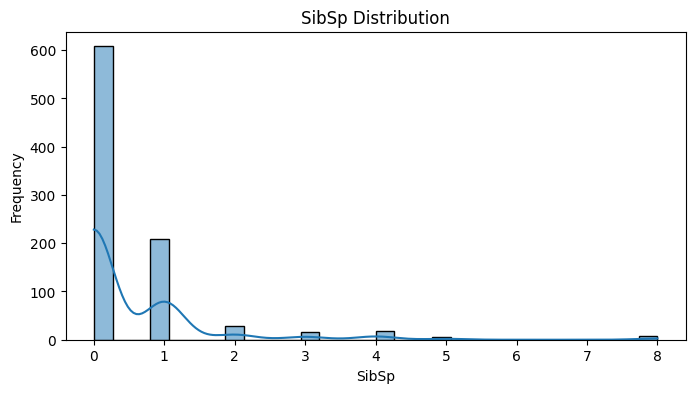

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(data['SibSp'].dropna(), bins=30, kde=True)
print(data['SibSp'].min())
print(data['SibSp'].max())
plt.title('SibSp Distribution')
plt.xlabel('SibSp')
plt.ylabel('Frequency')
plt.show()


0
8


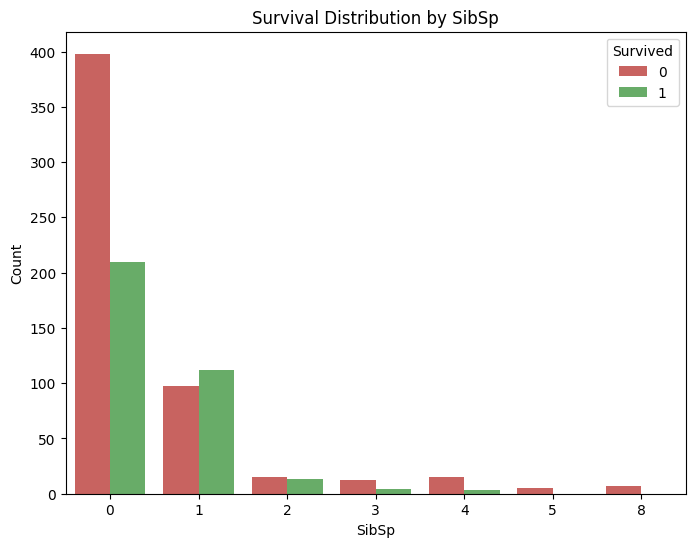

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['#d9534f', '#5cb85c']
sns.countplot(x='SibSp', hue='Survived', data=data, palette=colors)
print(data['SibSp'].min())
print(data['SibSp'].max())
plt.title('Survival Distribution by SibSp')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.show()


#### Distribución de 'Parch'

0
6


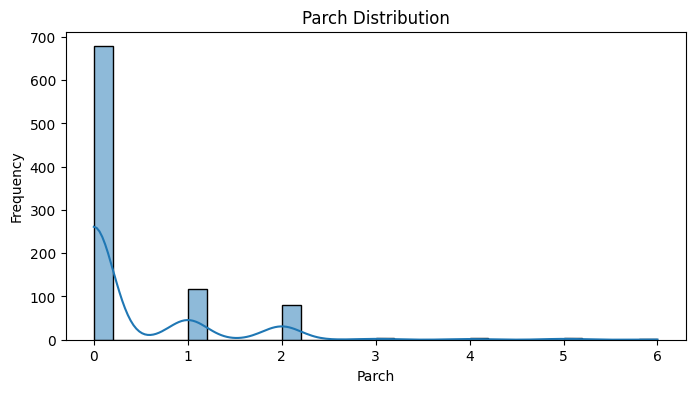

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(data['Parch'].dropna(), bins=30, kde=True)
print(data['Parch'].min())
print(data['Parch'].max())
plt.title('Parch Distribution')
plt.xlabel('Parch')
plt.ylabel('Frequency')
plt.show()

0
6


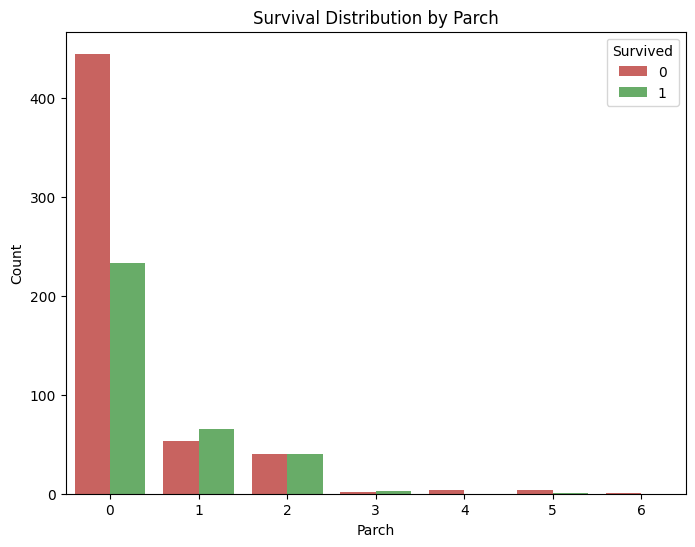

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['#d9534f', '#5cb85c']
sns.countplot(x='Parch', hue='Survived', data=data, palette=colors)
print(data['Parch'].min())
print(data['Parch'].max())
plt.title('Survival Distribution by Parch')
plt.xlabel('Parch')
plt.ylabel('Count')
plt.show()

### III. Aplicar técnicas de imputación para los datos faltantes. Seleccionar la mejor técnica y justificar la elección

#### Creación de la variable 'FamilySize' a partir de 'SibSp' y 'Parch'

In [ ]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [ ]:
data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S,2
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S,1
5,0,3,"Moran, Mr. James",male,25.891467,0,0,8.4583,Q,1
6,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,51.8625,S,1
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,S,5
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,11.1333,S,3
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,30.0708,C,2


#### Se elimina la variable 'Name' para el analisis de correlación

In [ ]:
data = data.drop(columns=['Name'])

## c. Análisis de correlación
### I. Realizar un análisis de correlación para decidir que características deben mantenerse y cuales descartarse
#### Matríz de correlación para datos númericos

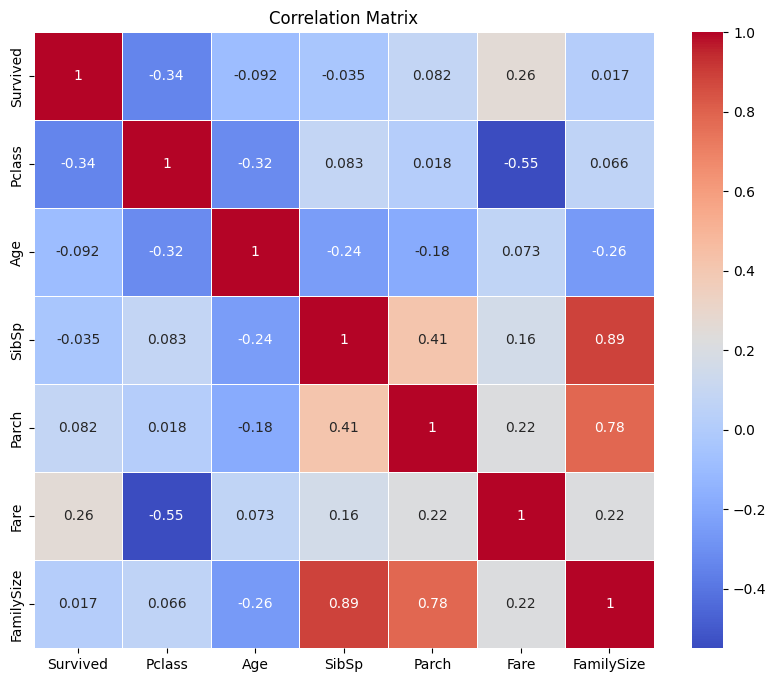

In [ ]:
correlation_matrix = data.drop(columns=['Sex', 'Embarked']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## d. Transformación de datos
### I. Convertir los datos categóricos en numéricos. Explorar diferentes métodos y seleccionar el más adecuado. Justifical la elección

#### Codificación de la variable 'Sex'

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

#### Codificación e imputación de la caracteriztica 'Embarked'

In [ ]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
for col in ['Embarked']:
    for i in range(len(data[col])):
        if data[col][i] == 'S':
            data[col][i] = 1
        elif data[col][i] == 'C':
            data[col][i] = 2
        elif data[col][i] == 'Q':
            data[col][i] = 3

<ipython-input-12-bf0e95355812>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = 1
<ipython-input-12-bf0e95355812>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = 2
<ipython-input-12-bf0e95355812>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = 1
<ipython-input-12-bf0e95355812>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [ ]:
data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,1,22.000000,1,0,7.2500,1,2
1,1,1,0,38.000000,1,0,71.2833,2,2
2,1,3,0,26.000000,0,0,7.9250,1,1
3,1,1,0,35.000000,1,0,53.1000,1,2
4,0,3,1,35.000000,0,0,8.0500,1,1
5,0,3,1,25.891467,0,0,8.4583,3,1
6,0,1,1,54.000000,0,0,51.8625,1,1
7,0,3,1,2.000000,3,1,21.0750,1,5
8,1,3,0,27.000000,0,2,11.1333,1,3
9,1,2,0,14.000000,1,0,30.0708,2,2


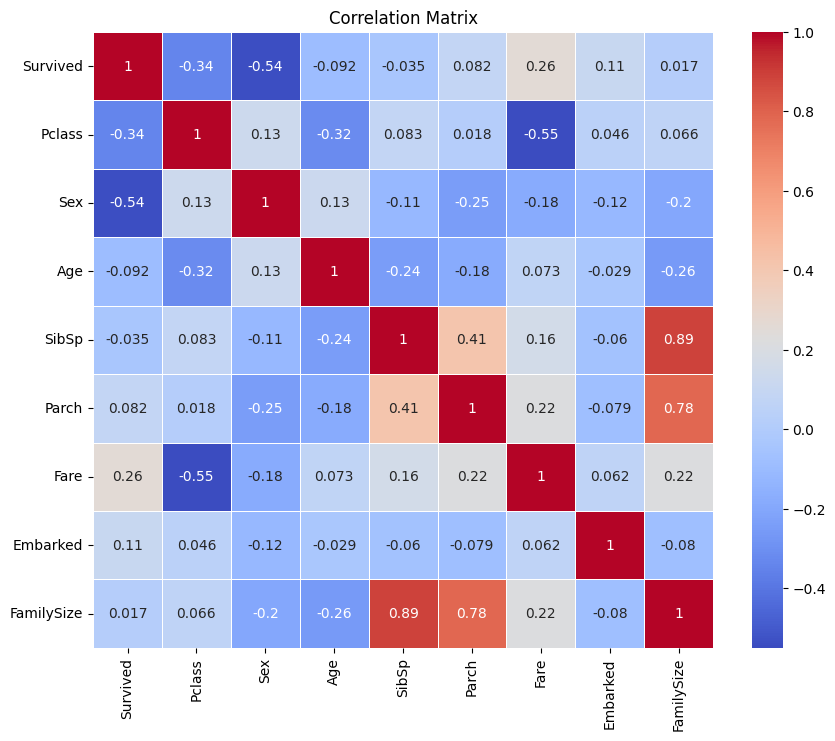

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Se descartan las variables que tienen menos correlación con la variable 'Survived'

In [ ]:
data = data.drop(columns=['Age', 'FamilySize', 'SibSp', 'Parch', 'Embarked'])
data.head(10)

,Survived,Pclass,Sex,Fare
0,0,3,1,7.2500
1,1,1,0,71.2833
2,1,3,0,7.9250
3,1,1,0,53.1000
4,0,3,1,8.0500
5,0,3,1,8.4583
6,0,1,1,51.8625
7,0,3,1,21.0750
8,1,3,0,11.1333
9,1,2,0,30.0708


#### Se normalizan los datos para el dataframe con los features seleccionados

Esto es especialmente importante para los modelos de clasificación basados en distancias como KNN, en donde no normalizar implica que no todas las características tendrían el mismo peso en la predicción de la label

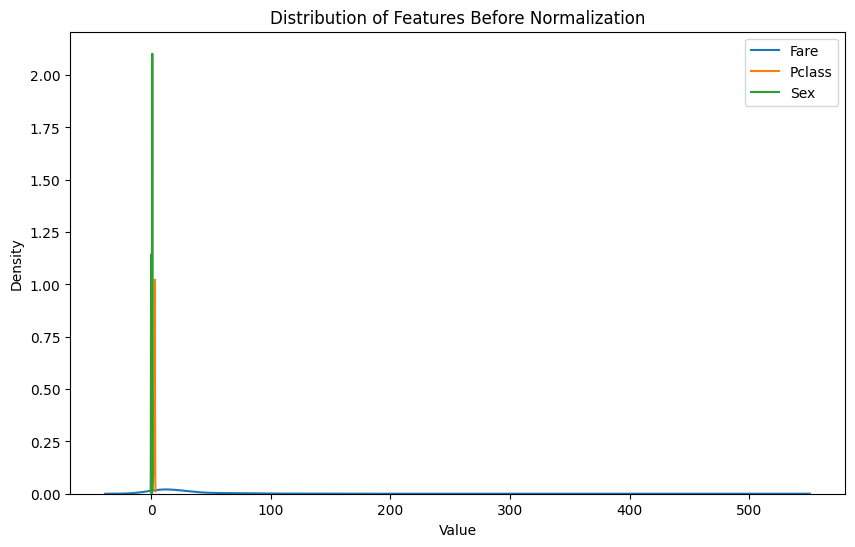

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data['Fare'])
sns.kdeplot(data['Pclass'])
sns.kdeplot(data['Sex'])
plt.title('Distribution of Features Before Normalization')
plt.legend(['Fare', 'Pclass', 'Sex'])
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

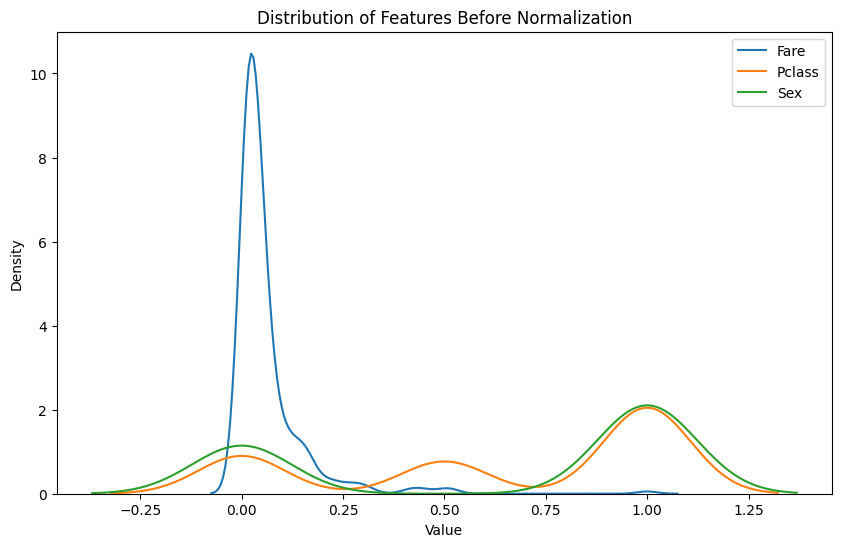

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['Fare']] = scaler.fit_transform(data[['Fare']])
data[['Pclass']] = scaler.fit_transform(data[['Pclass']])
data[['Sex']] = scaler.fit_transform(data[['Sex']])

plt.figure(figsize=(10, 6))
sns.kdeplot(data['Fare'])
sns.kdeplot(data['Pclass'])
sns.kdeplot(data['Sex'])
plt.title('Distribution of Features Before Normalization')
plt.legend(['Fare', 'Pclass', 'Sex'])
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# 2. Clasificación
## a. Selección de clasificadores:
### I. Elegir tres algoritmos de clasificación que se utilizarán en el proyecto. Justificar la selección de cada algoritmo.

## Logistic Regression, KNN, SVM


- **Logistic Regression:** Se eligió utilizar Logistic Regression debido a que este es un modelo lineal que es facil de entender y explicar, de la misma manera, produce probabilidades de pertenencia a una clase lo que permite interpretar los resultados en términos de riesgo. En el caso de los datos del Titanic, Permite interpretar variables explicativas para distribuir la probabilidad de supervivencia

- **KNN:** KNN no realiza suposiciones fuertes sobre la distribución de los datos, lo que nos permite hacerlo flexible y capaz de adaptarse a diferentes formas de los datos, debido a la baja dimensionalidad de los datos, se considería bueno en este espacio. De la misma manera, el conjunto de datos puede interactuar de maneras no lineales y KNN es utilizada para encontrar estas relaciones.

- **SVM:** *Support Vector Machine* es un elemento que maneja datos no lineales. SVM nos sirve al igual que KNN para encontrear y manejar relaciones más especificas y comnplicadas donde los datos no son lineales.

- **Random Forest:** Un modelo que trabajo mejor para datos no valanceados, y categóricos, nos aseguramos que con el número de arboles de desición correctos poderemos encontrar la mejor predicción.

### Manejo de los datos antes del entrenamiento


In [ ]:
from sklearn.model_selection import train_test_split

# Separar los datos de train en test y train
X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
print(X)
print(y)

     Pclass  Sex      Fare
0       1.0  1.0  0.014151
1       0.0  0.0  0.139136
2       1.0  0.0  0.015469
3       0.0  0.0  0.103644
4       1.0  1.0  0.015713
..      ...  ...       ...
886     0.5  1.0  0.025374
887     0.0  0.0  0.058556
888     1.0  0.0  0.045771
889     0.0  1.0  0.058556
890     1.0  1.0  0.015127

[891 rows x 3 columns]
0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


### Logistic Regression

#### Modelo

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Cross validation

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuracy for each fold: {scores}')
print(f'Mean Accuracy: {scores.mean()}')
print(f'Standard Deviation of Accuracy: {scores.std()}')

Accuracy for each fold: [0.7972028  0.81118881 0.75352113 0.75352113 0.82394366]
Mean Accuracy: 0.7878755047769133
Standard Deviation of Accuracy: 0.029298010789372084


#### Regresión logística

In [ ]:
from sklearn.model_selection import train_test_split
y_pred = model.predict(X_eval)

#### Matriz de confusión

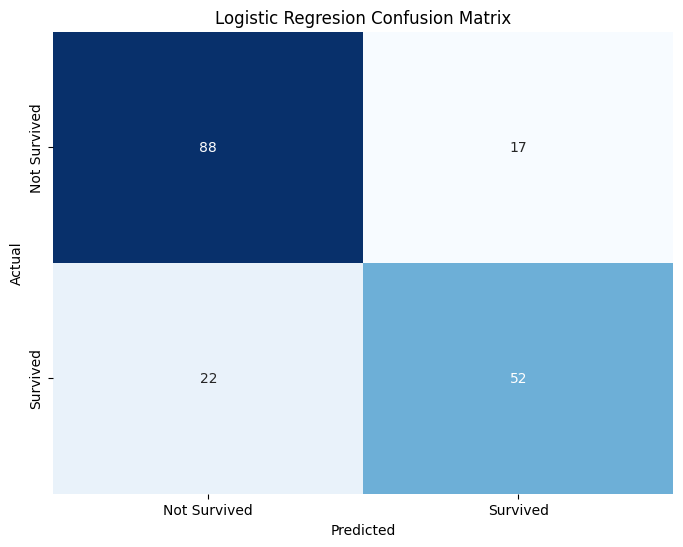

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

conf_matrix_reg = confusion_matrix(y_eval, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_reg, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Logistic Regresion Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
print(classification_report(y_eval, y_pred))
accuracy_log = accuracy_score(y_eval, y_pred)
f1_score_log = f1_score(y_eval, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa_log = cohen_kappa_score(y_eval, y_pred)
print(f'Kappa: {kappa_log}')

Kappa: 0.546246343841404


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_log, tpr_log, thresholds_log = roc_curve(y_eval, y_pred)
roc_auc_score_log = auc(fpr_log, tpr_log)

### KNN

#### Localizar la mejor **K** (Cross Validation)

Best k: 28


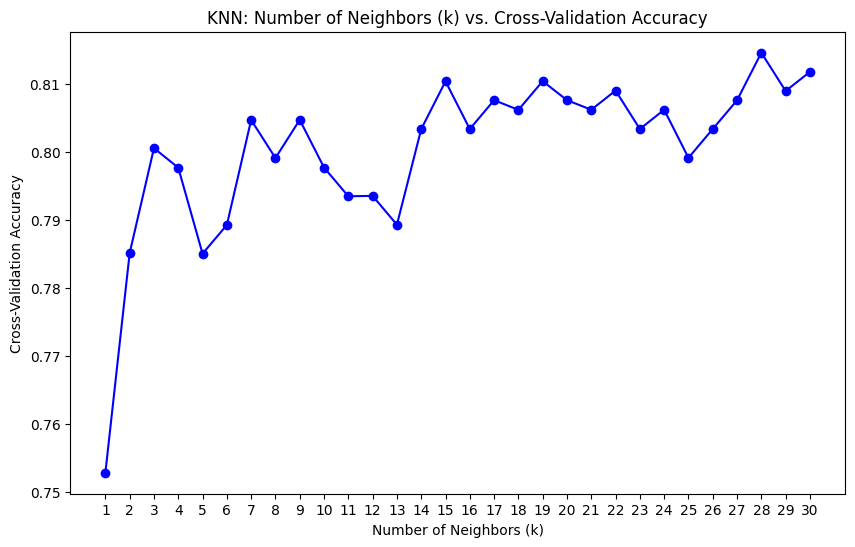

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': range(1, 31)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
grid_search.fit(X_train, y_train)
print(f"Best k: {grid_search.best_params_['n_neighbors']}")

mean_test_scores = grid_search.cv_results_['mean_test_score']
k_values = range(1, 31)

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('KNN: Number of Neighbors (k) vs. Cross-Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(k_values)
plt.show()

#### Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn = KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=28)

#### Cross Validation

In [ ]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuracy for each fold: {scores}')
print(f'Mean Accuracy: {scores.mean()}')
print(f'Standard Deviation of Accuracy: {scores.std()}')

Accuracy for each fold: [0.81118881 0.83916084 0.76056338 0.78169014 0.83802817]
Mean Accuracy: 0.8061262680980992
Standard Deviation of Accuracy: 0.03100885219157514


#### Predictions

In [ ]:
y_pred = knn.predict(X_eval)
conf_matrix_knn = confusion_matrix(y_eval, y_pred)

#### Confusion Matrix

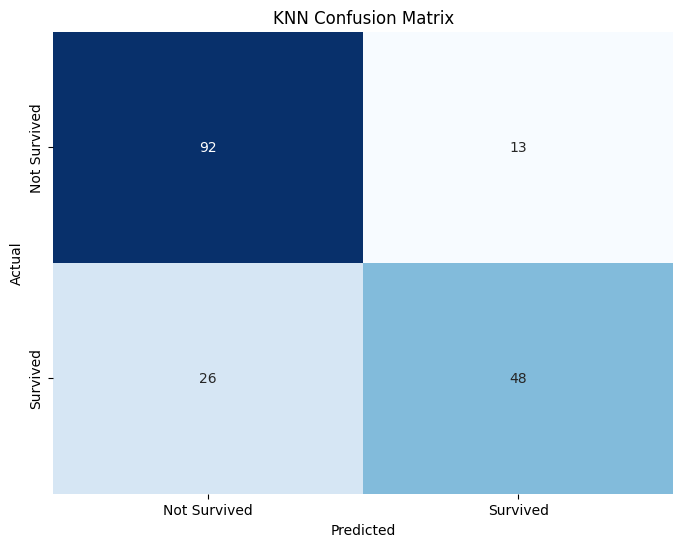

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_eval, y_pred))
accuracy_knn = accuracy_score(y_eval, y_pred)
f1_score_knn = f1_score(y_eval, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       105
           1       0.79      0.65      0.71        74

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



In [ ]:
kappa_knn = cohen_kappa_score(y_eval, y_pred)
print(f'Kappa: {kappa_knn}')

Kappa: 0.5388121820704235


In [ ]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_eval, y_pred)
roc_auc_score_knn = auc(fpr_knn, tpr_knn)

### SVM

#### Model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

#### Cross Validation

In [ ]:
scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuracy for each fold: {scores}')
print(f'Mean Accuracy: {scores.mean()}')
print(f'Standard Deviation of Accuracy: {scores.std()}')

Accuracy for each fold: [0.7972028  0.81118881 0.75352113 0.75352113 0.82394366]
Mean Accuracy: 0.7878755047769133
Standard Deviation of Accuracy: 0.029298010789372084


#### Predicciones


In [ ]:
y_pred = svm.predict(X_eval)
conf_matrix_svm = confusion_matrix(y_eval, y_pred)

#### Confusion matrix

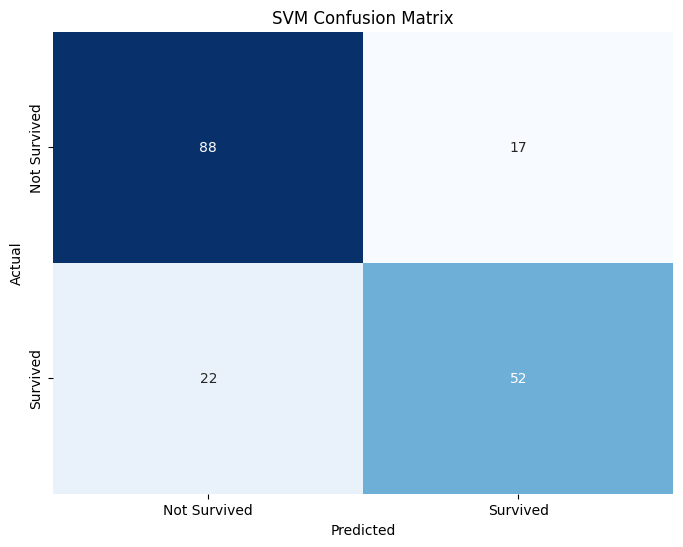

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])

plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
print(classification_report(y_eval, y_pred))
accuracy_svm = accuracy_score(y_eval, y_pred)
f1_score_svm = f1_score(y_eval, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



In [ ]:
kappa_svm = cohen_kappa_score(y_eval, y_pred)
print(f'Kappa: {kappa_svm}')

Kappa: 0.546246343841404


In [ ]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_eval, y_pred)
roc_auc_score_svm = auc(fpr_svm, tpr_svm)

### Random Forest

Best parameters: {'n_estimators': 150}
Best accuracy: 0.8061755146262188


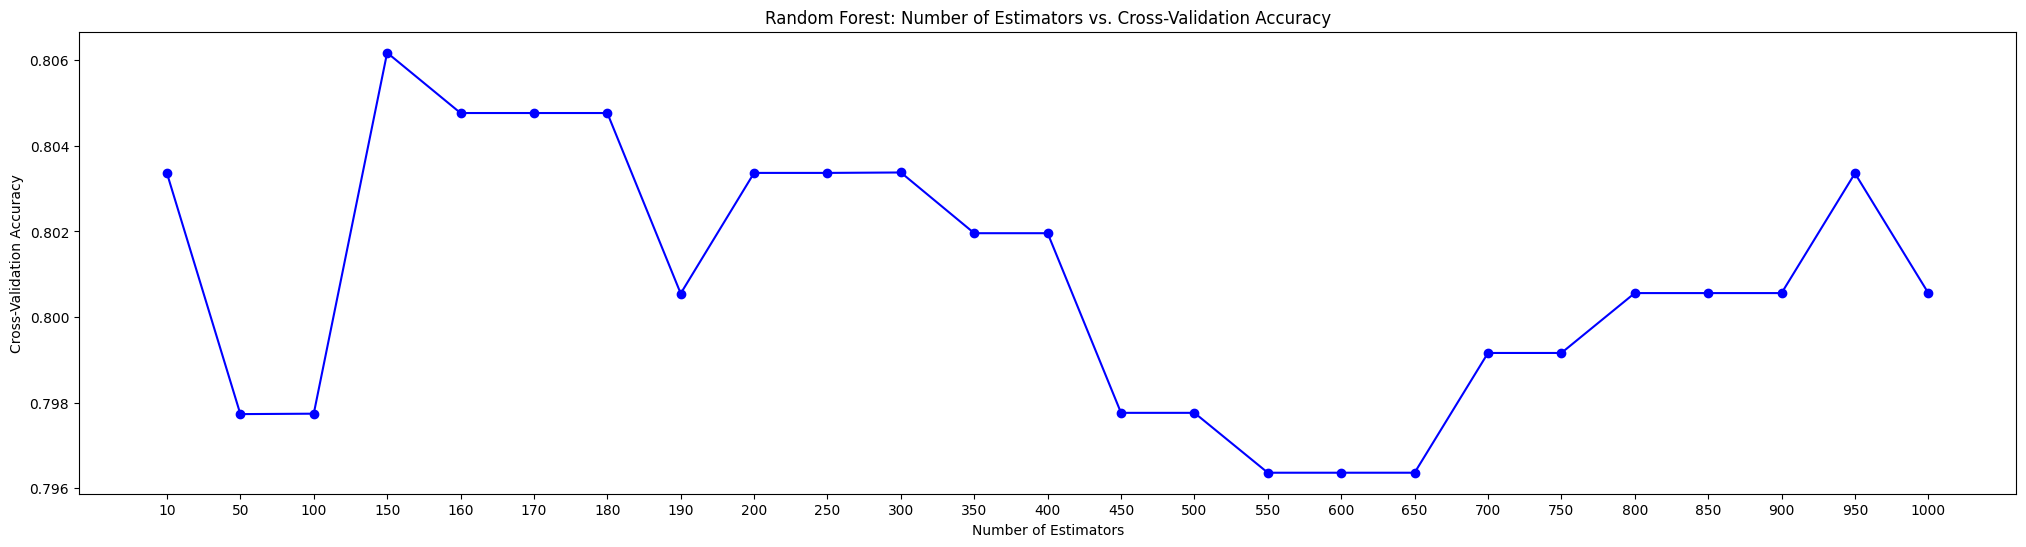

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rand_for = RandomForestClassifier(random_state=42)

grid = {'n_estimators': [10, 50, 100, 150, 160, 170, 180, 190, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]}

grid_search = GridSearchCV(rand_for, grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")
plt.figure(figsize=(25, 6))
plt.plot(grid_search.cv_results_['mean_test_score'], marker='o', linestyle='-', color='b')
plt.title('Random Forest: Number of Estimators vs. Cross-Validation Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(range(len(grid_search.cv_results_['mean_test_score'])), grid_search.cv_results_['param_n_estimators'])
plt.show()

#### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=150)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

#### Cross Validation

In [ ]:
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuracy for each fold: {scores}')
print(f'Mean Accuracy: {scores.mean()}')
print(f'Standard Deviation of Accuracy: {scores.std()}')

Accuracy for each fold: [0.82517483 0.78321678 0.8028169  0.79577465 0.79577465]
Mean Accuracy: 0.8005515611149414
Standard Deviation of Accuracy: 0.01383885272957992


#### Predicciones


In [ ]:
y_pred = forest.predict(X_eval)
conf_matrix_frst = confusion_matrix(y_eval, y_pred)

#### Confusion matrix

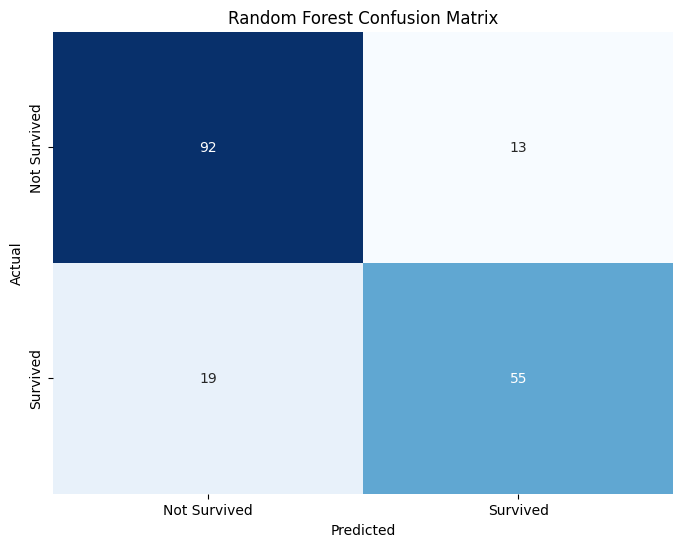

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_frst, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
print(classification_report(y_eval, y_pred))
accuracy_frst = accuracy_score(y_eval, y_pred)
f1_score_frst = f1_score(y_eval, y_pred)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [ ]:
kappa_frst = cohen_kappa_score(y_eval, y_pred)
print(f'Kappa: {kappa_frst}')

Kappa: 0.6269376058356129


In [ ]:
fpr_frst, tpr_frst, thresholds_frst = roc_curve(y_eval, y_pred)
roc_auc_score_frst = auc(fpr_frst, tpr_frst)

### Comparación de los modelos

####Accuracy de cada modelo

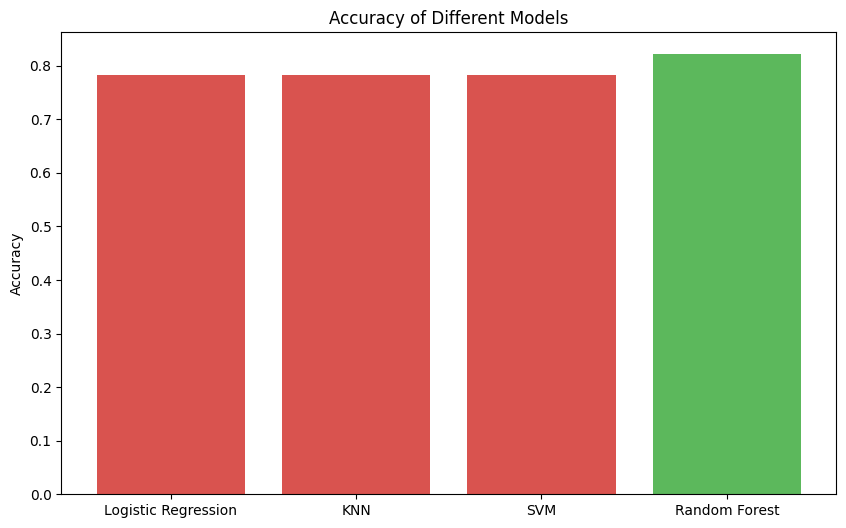

0.7821229050279329
0.7821229050279329
0.7821229050279329
0.8212290502793296


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['Logistic Regression', 'KNN', 'SVM', 'Random Forest'], [accuracy_log, accuracy_knn, accuracy_svm, accuracy_frst], color=['#d9534f', '#d9534f', '#d9534f', '#5cb85c'])
plt.title('Accuracy of Different Models')
plt.ylabel('Accuracy')
plt.show()
print(accuracy_log)
print(accuracy_knn)
print(accuracy_svm)
print(accuracy_frst)

#### F1-score de cada modelo

0.7272727272727273
0.711111111111111
0.7272727272727273
0.7746478873239436


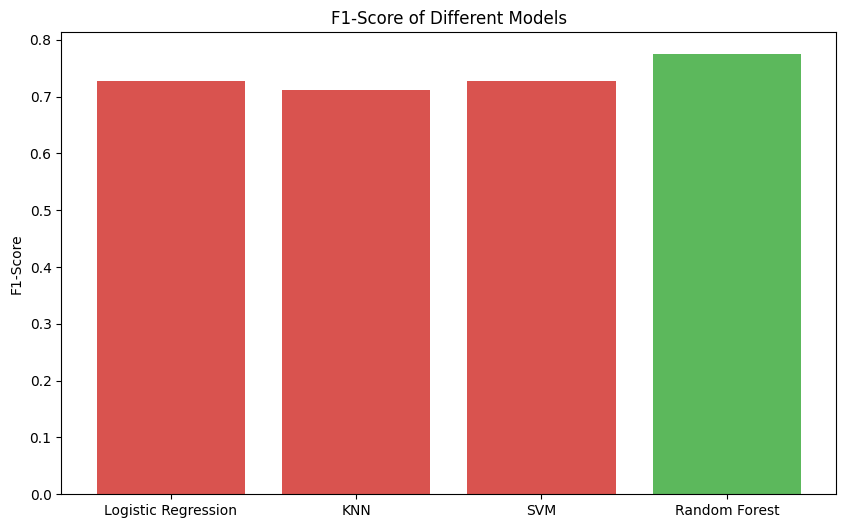

In [ ]:
print(f1_score_log)
print(f1_score_knn)
print(f1_score_svm)
print(f1_score_frst)

plt.figure(figsize=(10, 6))
plt.bar(['Logistic Regression', 'KNN', 'SVM', 'Random Forest'], [f1_score_log, f1_score_knn, f1_score_svm, f1_score_frst], color=['#d9534f', '#d9534f', '#d9534f', '#5cb85c'])
plt.title('F1-Score of Different Models')
plt.ylabel('F1-Score')
plt.show()

####Coeficiente Kappa para cada modelo

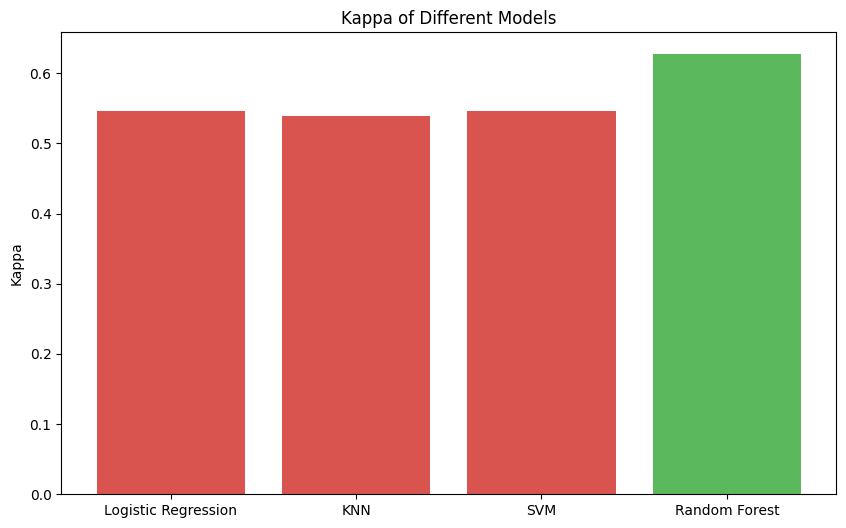

0.546246343841404
0.5388121820704235
0.546246343841404
0.6269376058356129


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['Logistic Regression', 'KNN', 'SVM', 'Random Forest'], [kappa_log, kappa_knn, kappa_svm, kappa_frst], color=['#d9534f', '#d9534f', '#d9534f', '#5cb85c'])
plt.title('Kappa of Different Models')
plt.ylabel('Kappa')
plt.show()
print(kappa_log)
print(kappa_knn)
print(kappa_svm)
print(kappa_frst)

####Curvas ROC

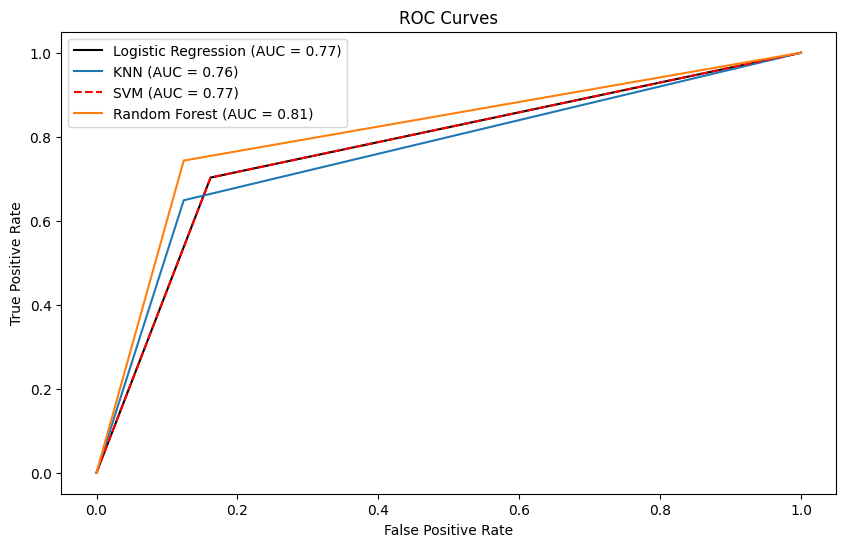

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='k', label='Logistic Regression (AUC = %0.2f)' % roc_auc_score_log)
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % roc_auc_score_knn)
plt.plot(fpr_svm, tpr_svm, '--', color='r', label='SVM (AUC = %0.2f)' % roc_auc_score_svm)
plt.plot(fpr_frst, tpr_frst, label='Random Forest (AUC = %0.2f)' % roc_auc_score_frst)
plt.legend()
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### II. Con base en estas métricas, determinar el mejor clasificador y justificar la elección.

El mejor clasificador en cuanto a los datos obtenidos, es Random Forest, debido a que los elementos que se obtuvieron de este se pueden considerar como los elementos mas precisos a los esperados. Se debe de considerar que en este caso no existe un elemento importante a considerar en el caso de falsos positivos o falsos negativos.

# Resultados finales con test.csv

Considerando los resultados obtenidos y determinando el mejor sistema para clasificar los datos como Random Forest, podemos predecir los datos de test.csv para determinar los sobrevivientes.

In [ ]:
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/RetoTitanic/titanic/test.csv')
real_test_values = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/RetoTitanic/titanic/gender_submission.csv')


test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data = test_data.drop(['Cabin', 'Ticket', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Age', 'Embarked'], axis=1)
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})

scaler = MinMaxScaler()
test_data[['Fare']] = scaler.fit_transform(test_data[['Fare']])
test_data[['Pclass']] = scaler.fit_transform(test_data[['Pclass']])
test_data[['Sex']] = scaler.fit_transform(test_data[['Sex']])


test_predict = forest.predict(test_data)

class_counts_p = pd.DataFrame(test_predict).value_counts()
class_counts_r = pd.DataFrame(real_test_values['Survived']).value_counts()

print(test_predict)


[0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 0 0 0]


In [ ]:
real_test_values = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/RetoTitanic/titanic/gender_submission.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/RetoTitanic/titanic/test.csv')

test_data['Survived'] = test_predict
predicted_test_values = test_data[['PassengerId', 'Survived']]
predicted_test_values.to_csv('predicted_test_values.csv', index=False)
